# Wk18 Lecture02 CodeAlong: UFOs

## Learning Objectives

- By the end of this CodeAlong, students will be able to:
   - Calculate time series statistics (rolling mean/std/diff/pct_change
   - Perform feature engineering for time series EDA 
   - Aggregate time series using date parts to answer stakeholder questions.

    

# 🕹️Part 1) Preparing Irregular-Interval Time Series

### Overview from Last Lecture

- 1) [ ] Convert the dates & times to a single column (if needed).
- 2) [ ] Convert the datetime column  (most likely a string) to a datetime data type.
- 3) [ ] Set the datetime column as the Series/DataFrame index
- 4) [ ] Resample the time series to the desired/correct frequency using the desired/correct aggregation method.
- 5) [ ] Impute null values (if required)


### UFO Sightings

- UFO Sightings: https://www.kaggle.com/datasets/NUFORC/ufo-sightings 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize'] = [10,5]

In [2]:
ufo  = pd.read_csv("Data/ufos-kaggle/scrubbed.csv", low_memory=False)
ufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556


## Is this regular or irregular (events)?

In [3]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(2), object(9)
memory usage: 6.7+ MB


## 1) Convert the dates & times to a single column (if needed).

Datetime is already one column.  Nothing to do here.

## 2) Converting Date Cols to Datetime

In [5]:
## Investigate the date format
ufo.loc[0,'datetime']

'10/10/1949 20:30'

In [6]:
## Set the date format
fmt = '%m/%d/%Y %H:%M'

In [7]:
## convert datetime to datetime
ufo['datetime'] = pd.to_datetime(ufo['datetime'], format=fmt)

ValueError: time data '10/11/2006 24:00' does not match format '%m/%d/%Y %H:%M' (match)

> Panda's is confused by 24:00. It doesn't know if we mean 0:00 of the NEXT day or if we mean the 11:59 pm (23:59) the same day

#### Handling Errors with pd.to_datetime

- Can use the `errors` argument for pd.to_datetime:
    - "raise" (default): raise an exception when errors happen
    - 'ignore': ignores the errors and returns the original value for that row. 
        - NOT RECOMMENDED: the entire column will not be datetime.
    - 'coerce': convert any bad datetime values to null values (NaT - NotATime)

>- **Branch point: we have a choice on how we deal with the bad timestamps.**
    -  Do we coerce them, make then null values, and drop them? Potentially losing a lot of data.
    - Or do we investigate a bit more to see if we can fix the problem without losing data.
    
    
- Let's see how much data we would lose if we chose to coerce the bad values:

In [8]:
## Check missing data before coerce
ufo['datetime'].isna().sum()

0

In [9]:
## Check missing data after coerce
coerced_dt = pd.to_datetime(ufo["datetime"], format=fmt, errors='coerce')
coerced_dt.isna().sum() / len(ufo)

0.008639147537718469

Should we drop the rows, or try to fix the times?

In [10]:
## Drop the rows


In [11]:
## Fix the errors: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              80332 non-null  datetime64[ns]
 1   city                  80332 non-null  object        
 2   state                 74535 non-null  object        
 3   country               70662 non-null  object        
 4   shape                 78400 non-null  object        
 5   duration (seconds)    80332 non-null  object        
 6   duration (hours/min)  80332 non-null  object        
 7   comments              80317 non-null  object        
 8   date posted           80332 non-null  object        
 9   latitude              80332 non-null  float64       
 10  longitude             80332 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 6.7+ MB


## 3) Setting datetime index

In [13]:
## Create ufo_ts by setting the datetime index
ufo_ts = ufo.set_index('datetime')
ufo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444


In [14]:
## Check index and frequency
ufo.index

DatetimeIndex(['1949-10-10 20:30:00', '1949-10-10 21:00:00',
               '1955-10-10 17:00:00', '1956-10-10 21:00:00',
               '1960-10-10 20:00:00', '1961-10-10 19:00:00',
               '1965-10-10 21:00:00', '1965-10-10 23:45:00',
               '1966-10-10 20:00:00', '1966-10-10 21:00:00',
               ...
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:15:00',
               '2013-09-09 22:00:00', '2013-09-09 22:00:00',
               '2013-09-09 22:20:00', '2013-09-09 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=80332, freq=None)

## 4) Resample Data to Desired Frequency

What frequency should we resample our data to?  This requires some thinking

### Let's visualize Our Data

<Axes: xlabel='datetime'>

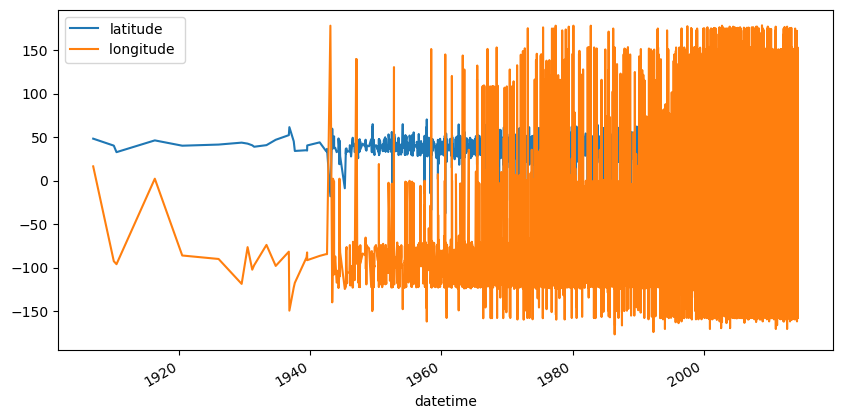

In [15]:
## Plot the full dataset
ufo_ts.plot()

> Hmmmm.... what are we *trying* to visualize?



**What do we really want to know about UFO's?**
- Duration of sighting?
- Location of sighting?
- Number of sightings?

### Converting to Daily Frequency

**We want to quantify the number of events that occurred within each interval.**

>- Q: How could we do this?

Resample by day and aggregate by the number of entries for each day


### Make `ts` from ufo_ts

In [ ]:
# Resample by day and number of sightings
ts = 

In [ ]:
# plot the ts
ts.plot()

In [ ]:
## Change figsize to 10,5
plt.rcParams['figure.figsize'] = [10,5]

In [ ]:
## Plot again
ts.plot()

Is all of this data relevant and interesting?  When did sightings really start becoming significant?


In [ ]:
## keep only recent data


In [ ]:
## Plot again
ts.plot()

# Part 2) Aggregating Full Dataset Using Date Parts

## 📝 **Stakeholder Questions to Answer**

**ANSWER TOGETHER:**
- 1) What Month and Year had the most sightings? (and how many sightings were there?)

- 2) Which month of the year has had the highest total number of reported sightings??
- 3) Is there a seasonal pattern to UFO sightings? If so, how long is the season?

- 4) Which US holiday has the largest number of sightings?
___
**ANSWER SELECTED Q's IN BREAKOUT ROOMS**

- 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

- 6) What day of the week has the highest reported sightings?

- 7) At what time of day (hour) do most sightings occur?

- 8) Which US state has the most sightings?

- 9) Which country had the largest proportion of sightings for the year 2000?

- 10) Have the types/shapes of UFO's witness changed over time?
    - Tip: use only the 4 most common shapes

### Making `eda_df` for answering questions

In order to access the datetime library of methods in Pandas, we will need to convert `datetime` back into a column.  A datetime index does not have the methods we need.

In [ ]:
## making eda_df with date as a column instead of index
eda_df = ufo_ts.reset_index()
eda_df

## Feature Engineering: Date Parts

- Datetime objects have:
    - year
    - month
    - month_name()
    - day
    - day_name()
    - hour
    - seconds
    
- Pandas has a `.dt.` accessor to use datetime methods on an entire column at once.

In [ ]:
## feature engineering for dates
eda_df['year'] = eda_df['datetime'] ##
eda_df['month'] = eda_df['datetime'] ##
eda_df['day of month'] = eda_df['datetime'] ##
eda_df['day of week'] = eda_df['datetime'] ##
eda_df['hour'] = eda_df['datetime'] ##
eda_df.head()

> Let's add a "weekend" feature that will be True if the day was a Saturday or Sunday.

In [ ]:
## let's add a weekend feature
eda_df['weekend'] = ##
eda_df.head()

#### Let's add a column for the decade

In [ ]:
## Calculate decade by subtracting the data modulo 10
eda_df['decade'] = ##
eda_df.head()

## 🕹️ Answering Stakeholder Questions (Together)

### Making `eda_ts` & `ts`

### 1) What Month/Year had the most sightings? (and how many sightings were there?)


In [ ]:
## make a ts that is resampled to monthly
eda_ts = 
eda_ts.head()

In [ ]:
## Resample to correct frequency


In [ ]:
## get the date of the max sightings


In [ ]:
# how many sightings?


In [ ]:
## Plot the ts and add vertical line at month with most sightings
ax = m_ts.plot();
fmt = "%m/%Y"
ax.axvline(date_most_ufos, ls='--',color='k', 
           label=f"{date_most_ufos.strftime(fmt)} had {ts.loc[date_most_ufos]}")
ax.legend()

### 2) Which month of the year has had the highest total number of reported sightings?

In [ ]:
## Check value counts of months in eda_df


### 3) Is there a seasonal pattern to recent UFO sightings? If so, how long is the season?

### Seasonality

In [ ]:
import statsmodels.tsa.api as tsa

In [ ]:
## Isolate just years since 2000 to capture recent trends


In [ ]:
## plot the sliced ts


In [ ]:
## Isolate trend and seasonal components with seasonal_decompose()


In [ ]:
## Plot the decomposition
seasonal = decomp.seasonal
ax = seasonal.plot(figsize=(12,3))
ax.set(ylabel='Change in # of Sightings',
      title='Seasonal Component of Sightings');

In [ ]:
## separate seasonal component and plot


### 4) Which US holiday has the largest number of sightings?

#### Feature Engineering: Holidays

In [ ]:
# !pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

In [ ]:
## Create an instance of the US country holidays.


In [ ]:
## create a test holiday 
test = "01/01/2015"
test

In [ ]:
## use .get() to test the api 


In [ ]:
## Map the api's .get method onto the df to get all holidays

## Check the unique holidays


Apparently Juneteenth has made it on there yet.

#### Answer to which holiday has most sightings:

In [ ]:
## Plot count of holiday sightings using sns.countplot()


#### Wait...when did **that** movie come out?

In [ ]:
release_date= '1997-07-03'

In [ ]:
## Plot the # of sightings over time and annotate the release date


### 7-day Rolling Mean of Daily Sightings
This is so noisy, let's try plotting a rolling mean.

### 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

In [ ]:
## Resample monthly ts as yearly

## Calculate percent change

In [ ]:
## Find the year with the biggest percent change (absolute value)


In [ ]:
## Plot the percent changes and add a line at the biggest


## 🏓**Breakout Rooms: Answering Stakeholder Questions**

**Choose 1-2 of the remaining questions and work in breakout rooms to answer them:**
- 5) Which year had the highest % increase in sightings compared to previous years?
- 6) What day of the week has the highest reported sightings?
- 7) At what time of day (hour) do most sightings occur?
- 8) Which US state has the most sightings?
- 9) Which country had the largest proportion of sightings for the year 2000?
- 10) Have the types/shapes of UFO's witness changed over time?
    - Tip: use only the 4 most common shapes



### 5) Which year had the highest % increase in sightings compared to previous years? (since 1950)

### 6) What day of the week has the highest reported sightings?

### 6) Which country had the largest proportion of sightings for the year 2000?

### 7) Have the types/shapes of UFO's witness changed over time?

___
# Bonus: Plotly Express

In [ ]:
import plotly.express as px
import plotly.io as pio

### Map Over Time

In [ ]:
eda_df = eda_df.sort_values('decade')
eda_df.columns = eda_df.columns.str.strip()
eda_df['latitude'] = pd.to_numeric(eda_df['latitude'], errors='coerce')
eda_df.head()

In [ ]:
px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade",
              template='ggplot2')